In [1]:
import pandas as pd
import numpy as np
import plotly as py
import matplotlib.pyplot as plt
import folium
import json
import urllib.request

from datetime import datetime,timedelta
#from sklearn.metrics import mean_squared_error
#from scipy.stats import norm
#from scipy.optimize import curve_fit
#from scipy.optimize import fsolve

#%matplotlib inline+

url_B = "https://data.brasil.io/dataset/covid19/caso_full.csv.gz"
url_G = "https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-100-mun.json"

# BR / Brasil - geojson/geojs-100-mun.json
# AL / Alagoas - geojson/geojs-27-mun.json
# BA / Bahia - geojson/geojs-29-mun.json
# CE / Ceará - geojson/geojs-23-mun.json
# MA / Maranhão - geojson/geojs-21-mun.json
# PB / Paraíba - geojson/geojs-25-mun.json
# PE / Pernambuco - geojson/geojs-26-mun.json
# PI / Piauí - geojson/geojs-22-mun.json
# RN / Rio Grande do Norte - geojson/geojs-24-mun.json
# SE / Sergipe - geojson/geojs-28-mun.json

req = urllib.request.urlopen(url_G)
content = req.read().decode('ansi')

geo = json.loads(content)

In [2]:
Norte = ["AC", "AM", "AP", "PA", "RO", "RR", "TO"]
Nordeste = ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE']
Sudeste = ['ES', 'MG', 'RJ', 'SP']
Sul = ['PR', 'RS', 'SC']
Centro_oeste = ['DF', 'GO', 'MT', 'MS']

Regiao = [Nordeste, Norte, Sudeste, Sul, Centro_oeste]
reg = ['Nordeste', 'Norte', 'Sudeste', 'Sul', 'Centro Oeste']

In [3]:
df = pd.read_csv(url_B, sep = ",")
df1 = df.drop(['epidemiological_week', 'last_available_date', 'is_repeated'], axis = 1)
df1.rename(columns={'last_available_confirmed' : 'confirmed', 'last_available_confirmed_per_100k_inhabitants' : 'incidence',
                    'estimated_population_2019' : 'population','last_available_deaths' : 'deaths',
                    'last_available_death_rate' : 'death_rate', 'order_for_place' : 'day'}, inplace = True)

In [4]:
df_hoje = df1.loc[df['is_last'] == True, :]

label = ["Cidade", "Código IBGE", "Dia", "Último Dado", "Casos Confirmados", "Incidência de Casos", "Mortalidade", "Óbitos Confirmados", "Estado", "Novos Casos", "Novas Mortes"]
color = ['#e8615d', '#f49436', '#2d9de5', '#3bbdbd', '#634792']
color2 = ['#00876c', '#379469', '#58a066', '#78ab63', '#98b561', '#b8bf62', '#dac767',
          '#deb256', '#e09d4b', '#e18745', '#e06f45', '#dc574a', '#d43d51']

In [5]:
for r in range(len(Regiao)) :
    for a in range(len(Regiao[r])) :
        df1.loc[df1['state'].eq(Regiao[r][a]), 'region'] = reg[r]

In [6]:
FMT = '%Y-%m-%d'

#date = df['date']
#df1['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-02-25", FMT)).days)

In [7]:
df_estados = df1.loc[df['city'].isnull(), :].drop(['place_type'], axis = 1)
df_estados.reset_index(drop = True, inplace = True)

df_estados = df_estados[['state', 'region', 'population', 'is_last', 'date', 'day',
                         'confirmed', 'deaths', 'new_confirmed', 'new_deaths', 'incidence', 'death_rate']]         
 
df_Brasil = df_estados.drop(['is_last', 'population', 'day'], axis = 1)
df_Brasil = df_Brasil.groupby('date').sum()

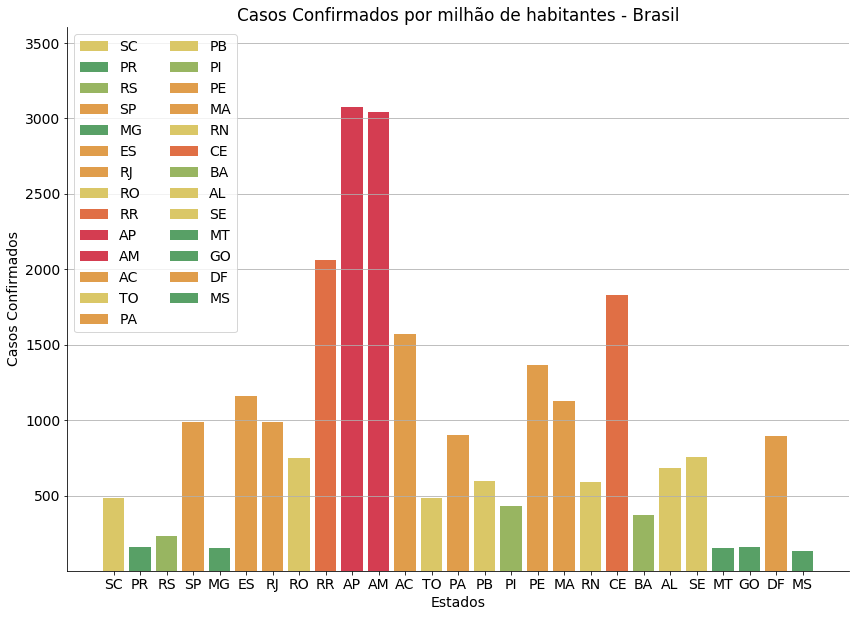

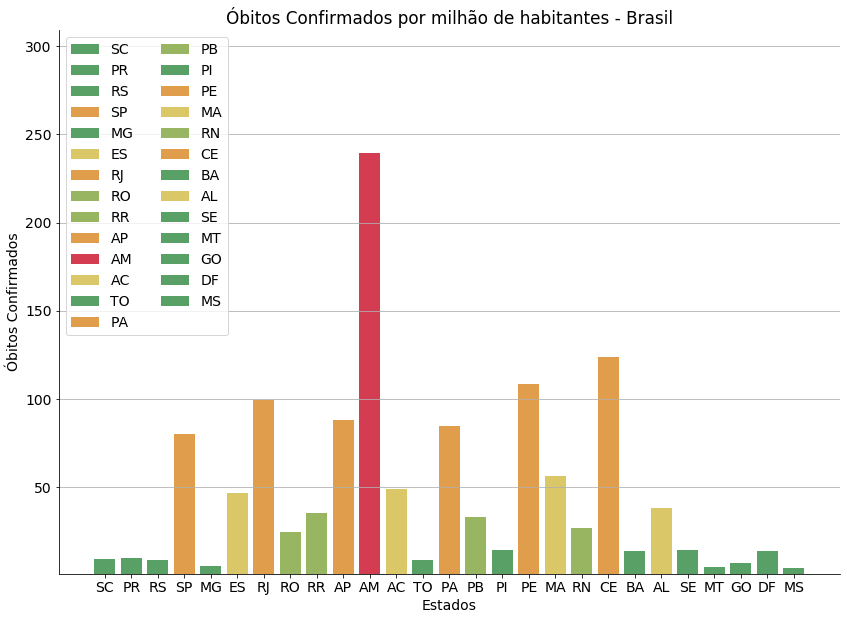

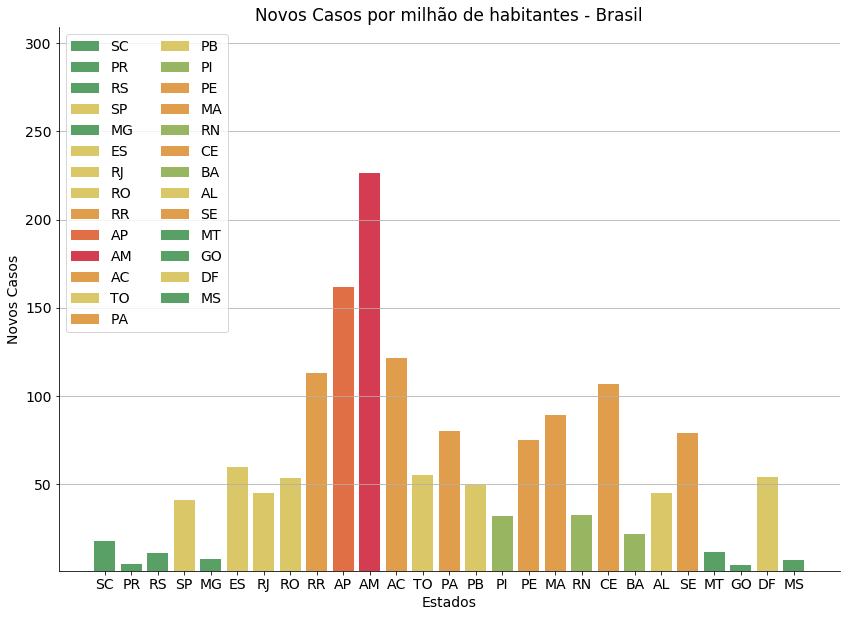

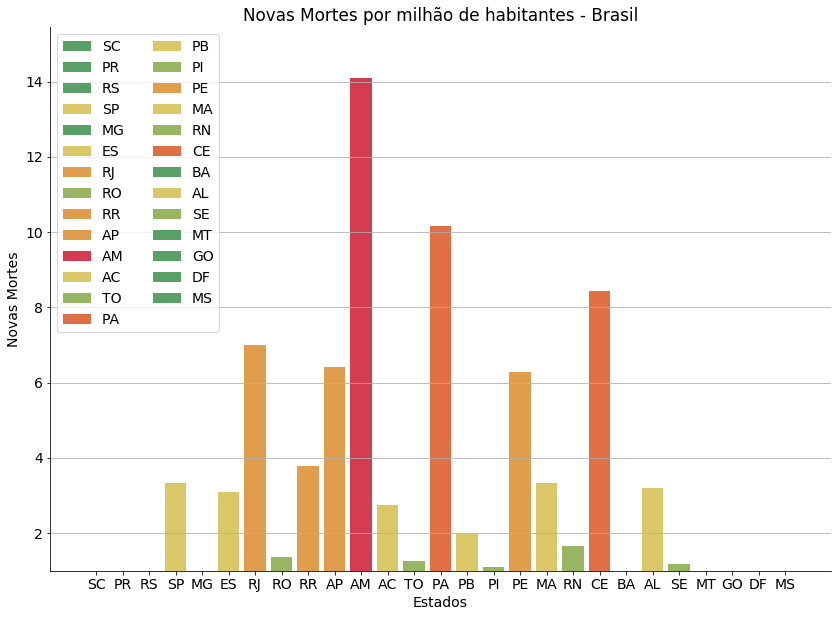

In [8]:
label = ["Estado", "Regiao", "População", "Último Dado", "Data", "Dia", "Casos Confirmados",
         "Óbitos Confirmados", "Novos Casos", "Novas Mortes", "Incidência de Casos", "Mortalidade"]

for f in range(6, 10) :
        
    plt.rc('font', size=14)
    plt.rcParams['figure.figsize'] = [14, 10]

    plt.gca().spines["top"].set_visible(False)    
    plt.gca().spines["right"].set_visible(False)
    plt.gca().get_xaxis().tick_bottom()    
    plt.gca().get_yaxis().tick_left()
    plt.grid(True, axis = 'y')


    estados = list(df_estados.loc[df_estados['is_last'],
                                  ['state', 'region']
                                 ].sort_values('region', ascending = False)['state'].unique())

    y_max = 0
    yp_max = 0

    for e in range(27) :      
        y = np.mean(df_estados.loc[(df_estados['state'] == estados[e]), 
                                   :].sort_values('day', ascending = True).iloc[:-1, f].tail(7))
        
        pop = max(df_estados.loc[(df_estados['state'] == estados[e]) & (df_estados['is_last']), 
                                 ['population', df_estados.columns[f]]].loc[:, 'population'])
        
        yp = (10 ** 6) * y / pop

        yp_max = [3500, 300, 300, 15]
        
        ratio = yp / yp_max[f - 6]
        
        if ratio < .0625 :
            plt.bar(estados[e], yp, label = estados[e], color = color2[-11])
        elif (ratio >= .0625) & (ratio <= .125) :   
            plt.bar(estados[e], yp, label = estados[e], color = color2[-9])
        elif (ratio >= .125) & (ratio <= .25) :
            plt.bar(estados[e], yp, label = estados[e], color = color2[-7])
        elif (ratio >= .25) & (ratio <= .5) :
            plt.bar(estados[e], yp, label = estados[e], color = color2[-5])
        elif (ratio >= .5) & (ratio <= .75) :
             plt.bar(estados[e], yp, label = estados[e], color = color2[-3])
        else  :
            plt.bar(estados[e], yp, label = estados[e], color = color2[-1])
        
    plt.ylim(1, yp_max[f - 6] * 1.03)    
        
    plt.title(label[f] + " por milhão de habitantes - Brasil")
    plt.legend(loc = 2, ncol = 2)
    plt.xlabel('Estados')
    plt.ylabel(label[f])
    plt.savefig('Graphics/' + label[f] + " 1M.png")
    plt.show()

In [9]:
df_cidades = df1.loc[df['place_type'].eq('city'), :].drop(['place_type'], axis = 1)
df_cidades = df_cidades.loc[(df_cidades["city"] != 'Importados/Indefinidos'), :]

df_cidades = df_cidades[['city', 'state', 'region', 'population', 'is_last', 'date', 'day',
                         'confirmed', 'deaths', 'new_confirmed', 'new_deaths']]

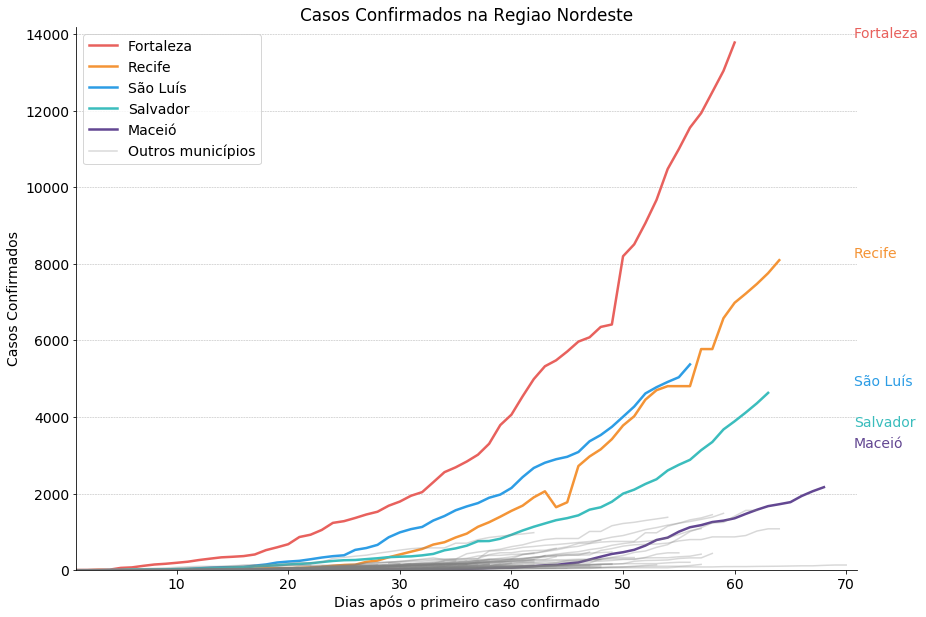

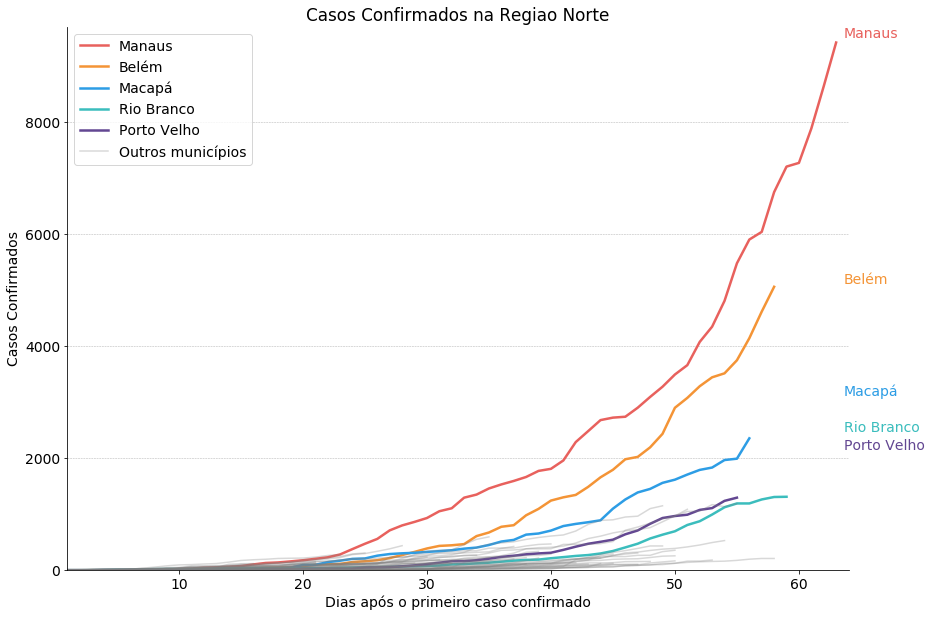

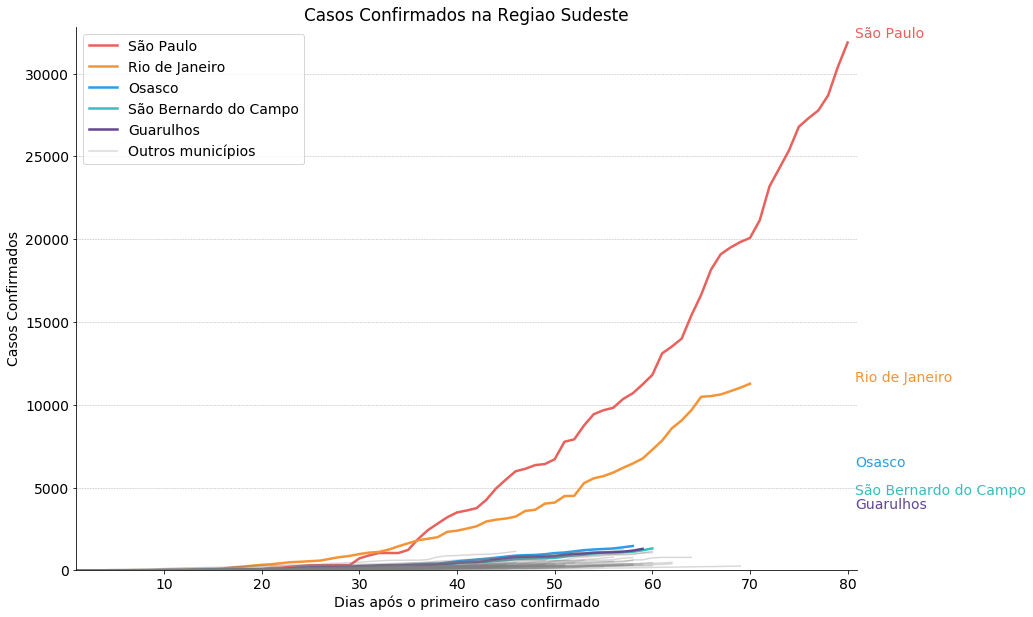

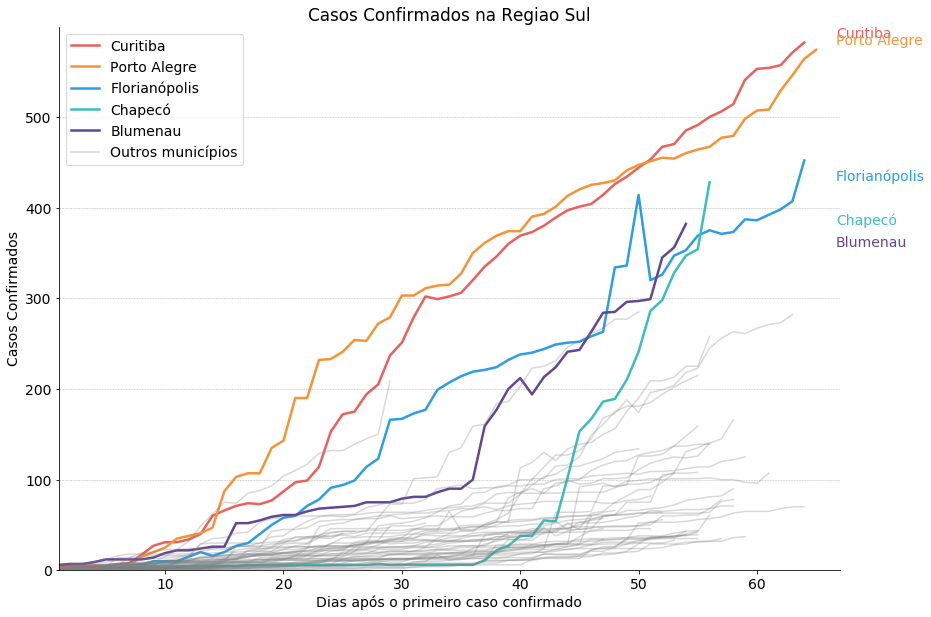

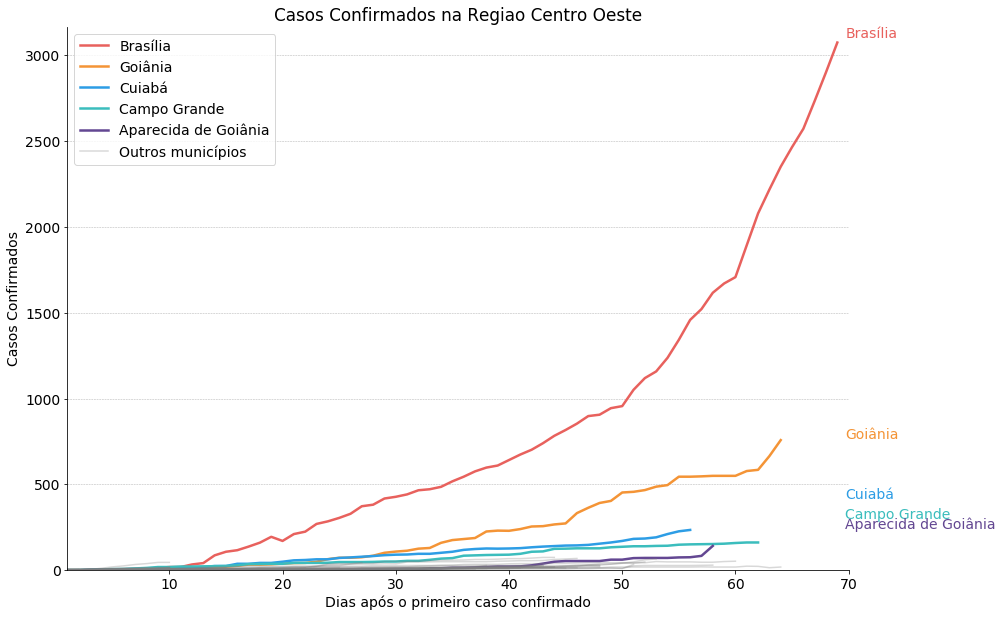

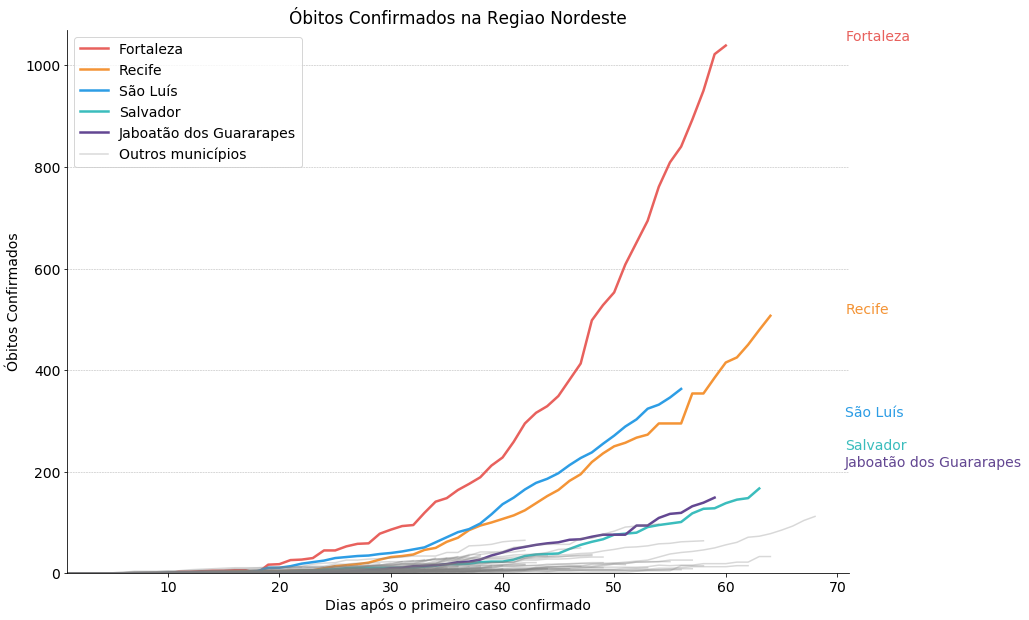

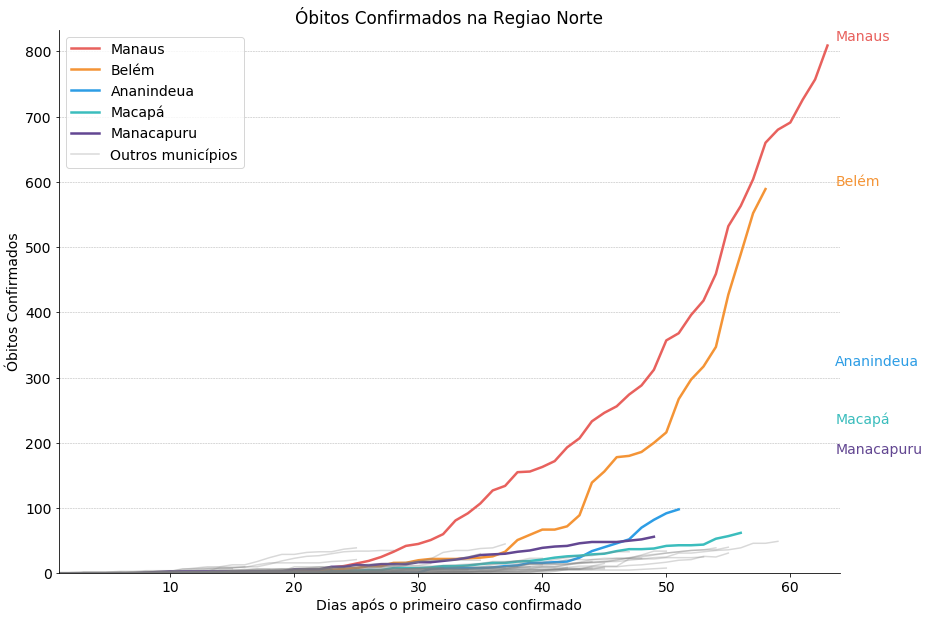

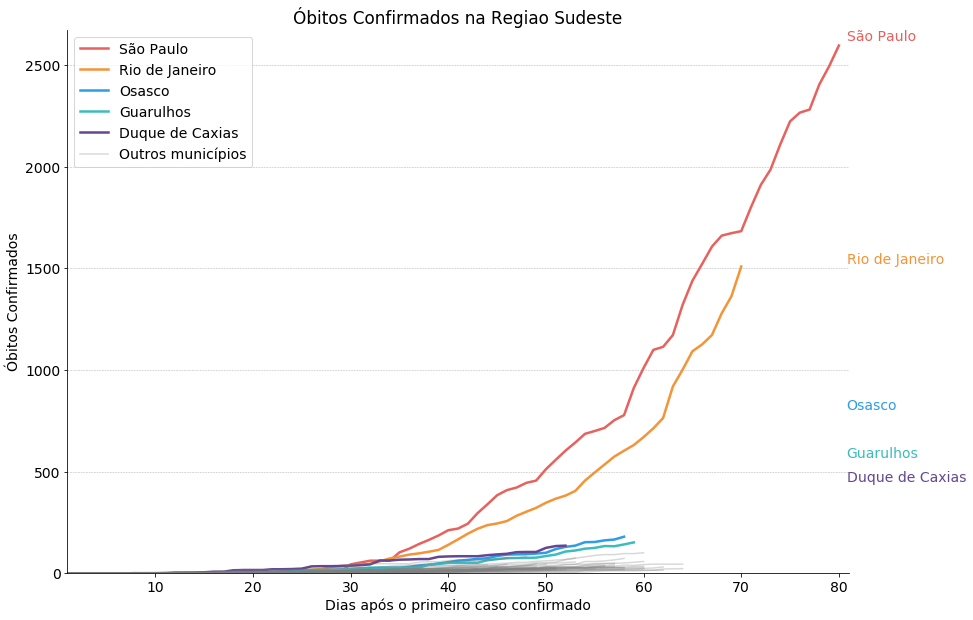

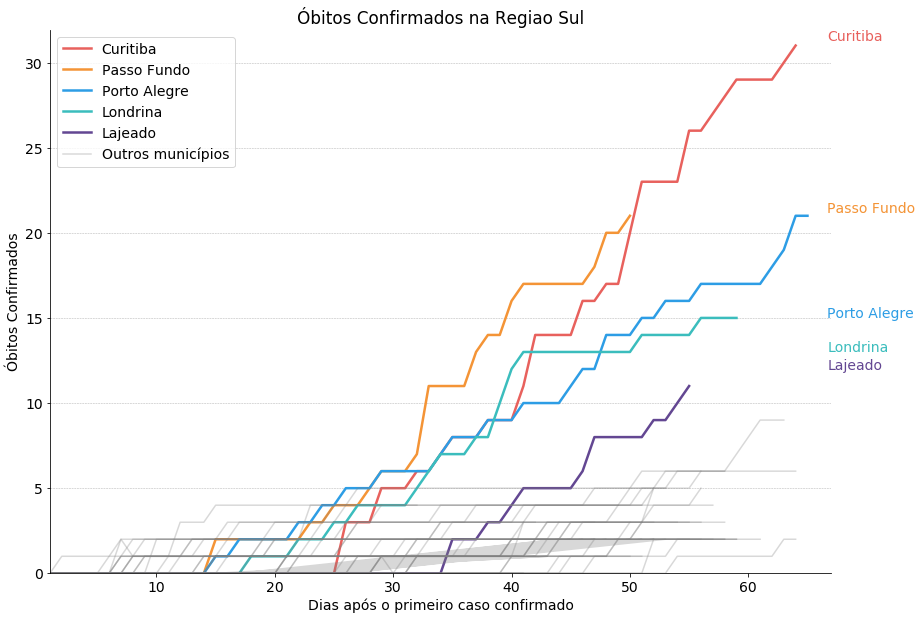

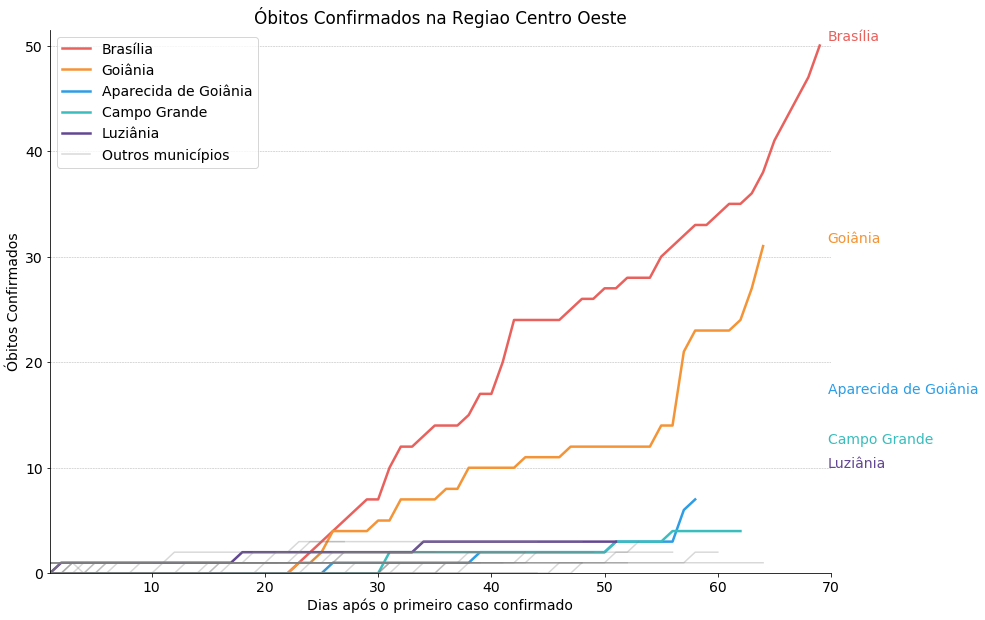

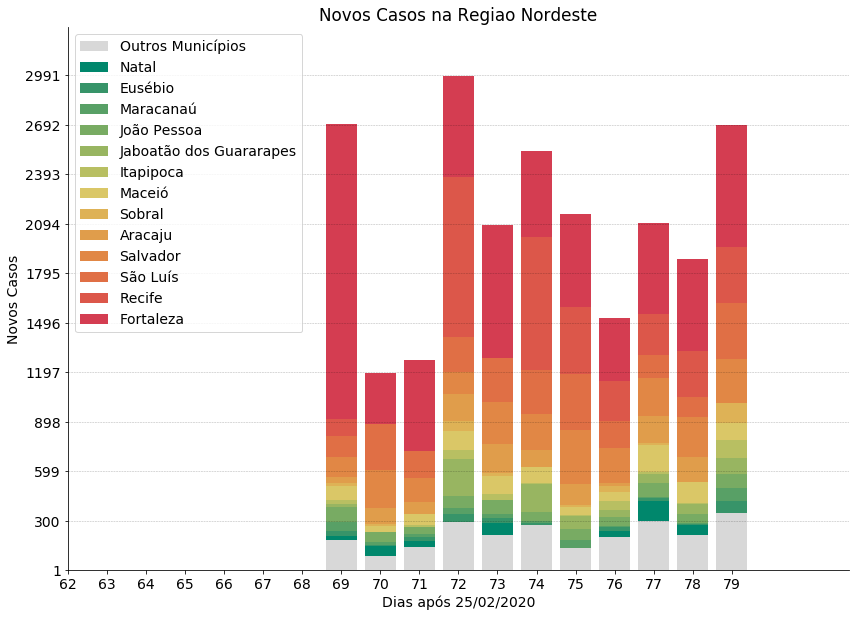

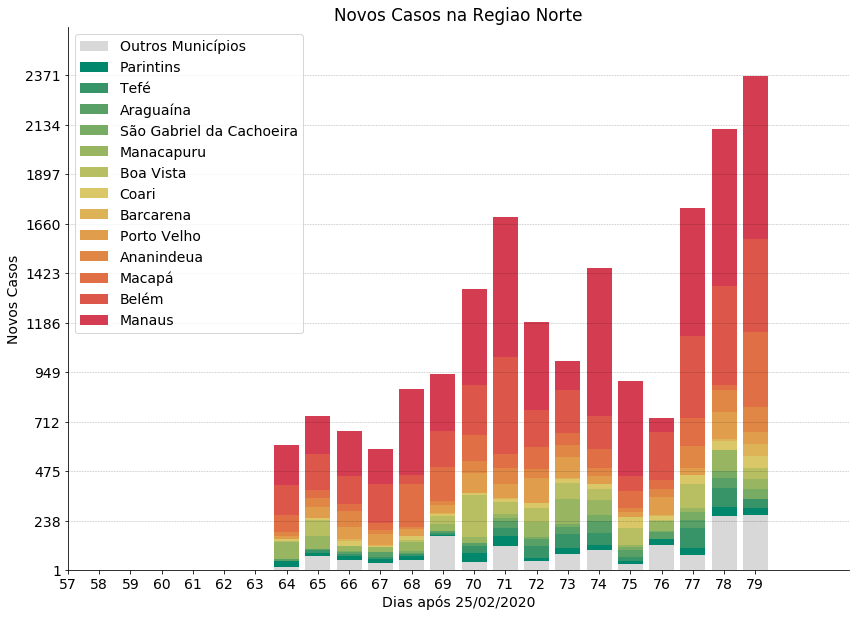

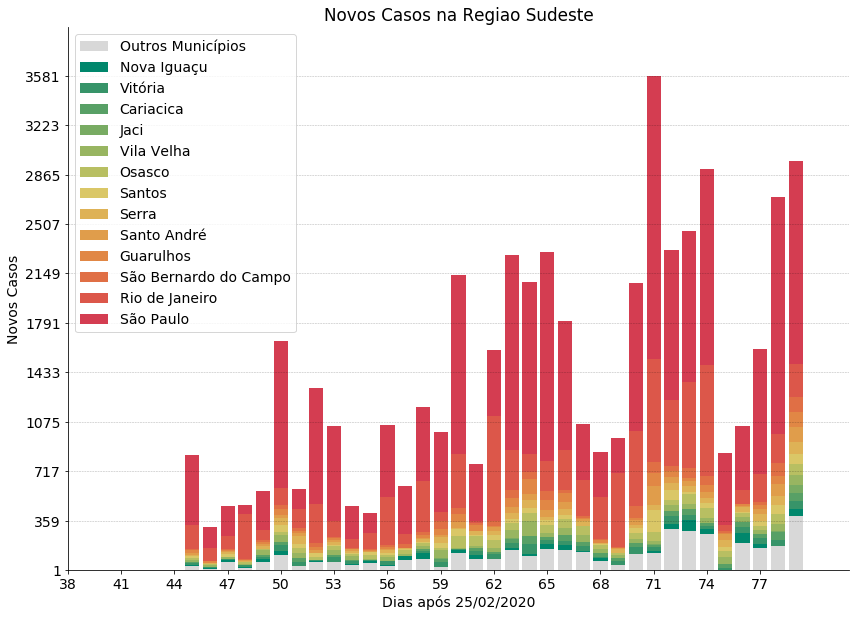

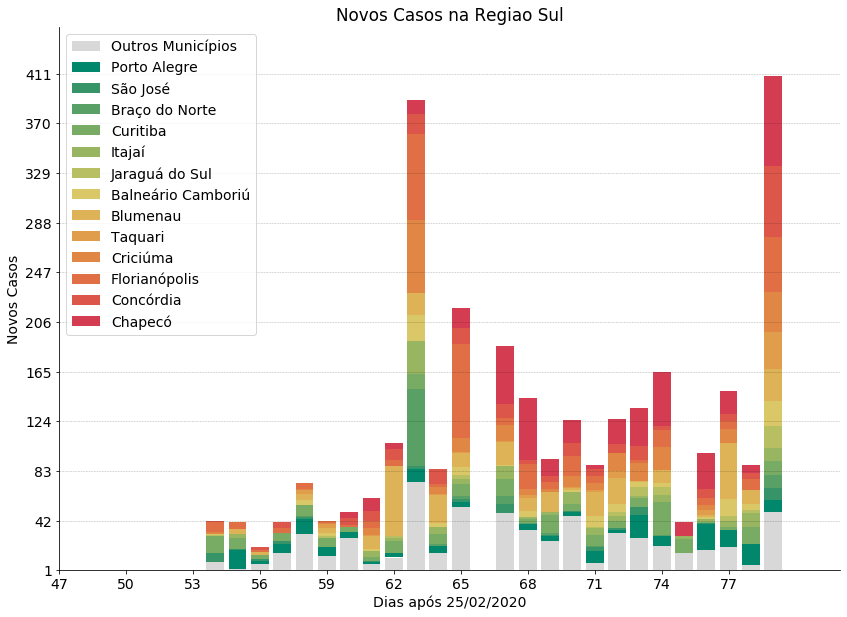

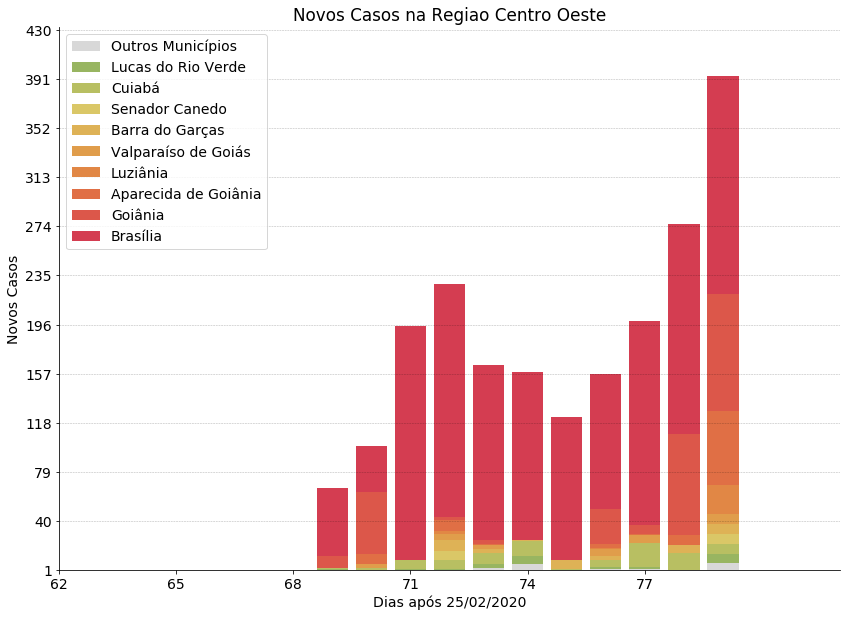

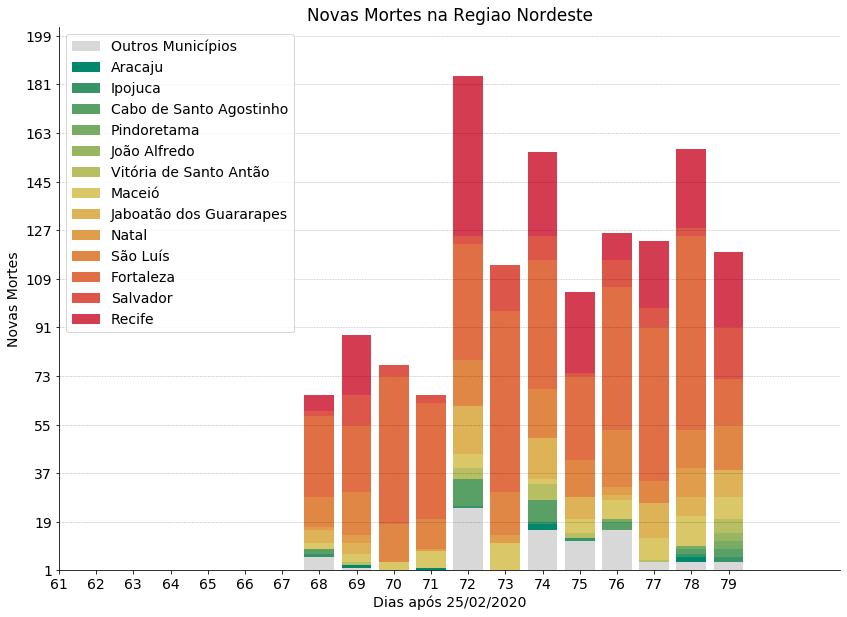

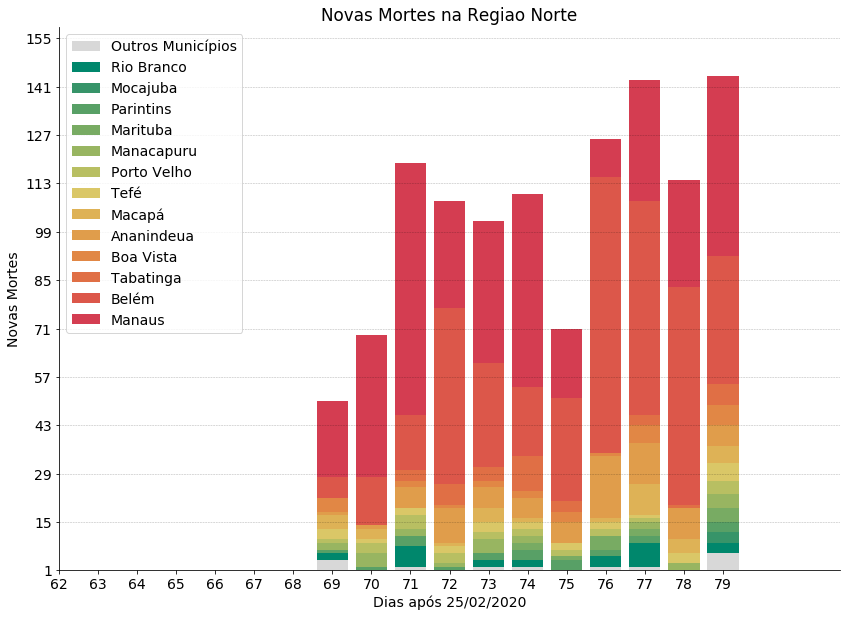

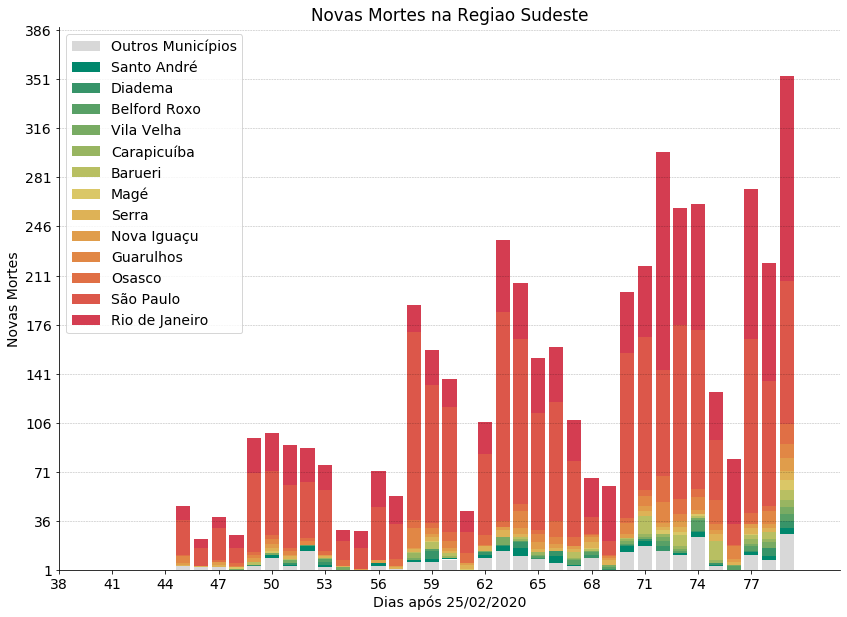

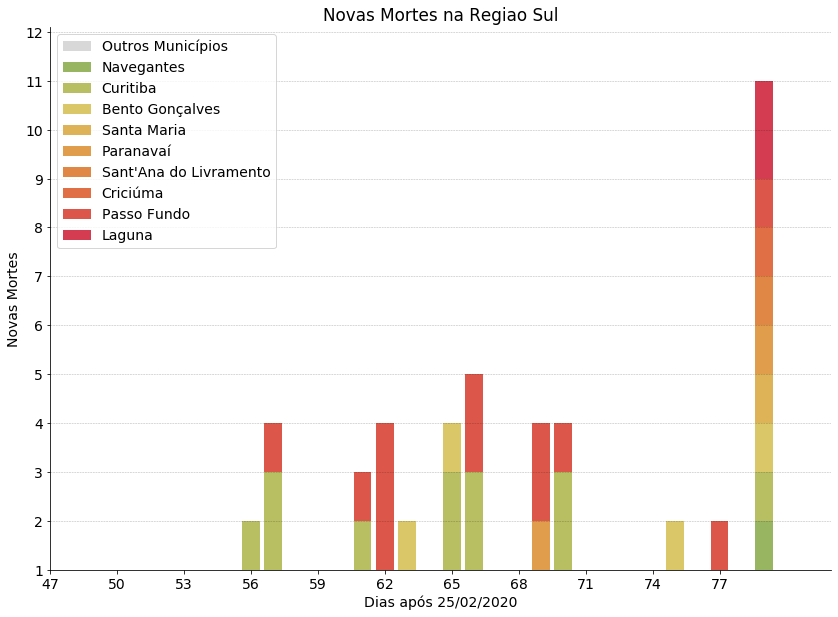

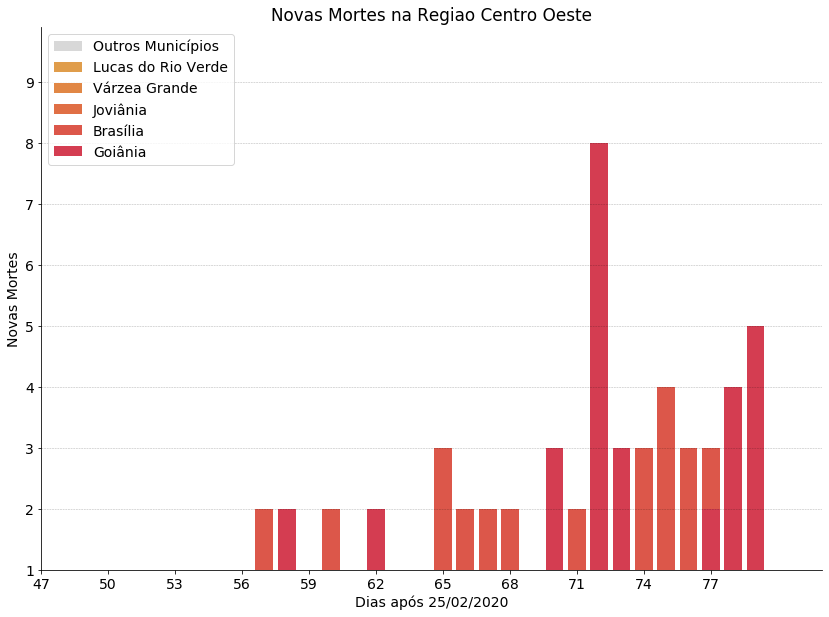

In [14]:
label = ["Cidade", "Estado", "Região", "População", "Último dado", "Data", "dia", "Casos Confirmados", 
           "Óbitos Confirmados", "Novos Casos", "Novas Mortes", "Incidência de Casos", "Mortalidade"]

reg = ['Nordeste', 'Norte', 'Sudeste', 'Sul', 'Centro Oeste']

for f in range(7, 11) :
    for r in range(5) :
        
        plt.rc('font', size = 14)
        plt.rcParams['figure.figsize'] = [14, 10]
        plt.tick_params(axis = "both", which = "both", bottom = "off", top = "off",    
                        labelbottom = "on", left = "off", right = "off", labelleft = "on")
        
        plt.grid(True, axis = 'y', linestyle = "dashed", lw = 0.5, color = "black", alpha = 0.3)
        plt.gca().spines["top"].set_visible(False)    
        plt.gca().spines["right"].set_visible(False)
        plt.gca().get_xaxis().tick_bottom()    
        plt.gca().get_yaxis().tick_left()
        
        dia = max(df_cidades[(df_cidades['region'] == reg[r])].loc[:, 'day'])
        
        x_max = dia
        y_max = 0
        
        if f in [7, 8] :
            Regiao_c = list(df_cidades[(df_cidades['region'] == reg[r]) &
                               (df_cidades['is_last'])].sort_values(df_cidades.columns[f],
                                                                    ascending = False)['city'].unique())           
            
            y_max = max(df_cidades.loc[(df_cidades['region'] == reg[r]) &
                                        (df_cidades['city'] == Regiao_c[0]), df_cidades.columns[f]])
            y_med = max(df_cidades.loc[(df_cidades['region'] == reg[r]) &
                                        (df_cidades['city'] == Regiao_c[1]), df_cidades.columns[f]])
            y_min = max(df_cidades.loc[(df_cidades['region'] == reg[r]) &
                                        (df_cidades['city'] == Regiao_c[5]), df_cidades.columns[f]])
            
            for c in range(len(Regiao_c)) : 
                # Real data
                x = list(df_cidades.loc[(df_cidades['region'] == reg[r]) & 
                                        (df_cidades['city'] == Regiao_c[c]), 'day'])
                y = list(df_cidades.loc[(df_cidades['region'] == reg[r]) &
                                        (df_cidades['city'] == Regiao_c[c]), df_cidades.columns[f]])

                if (c > 5) & (c < 50) :
                    plt.plot(x, y, marker = ' ', color = (.5, .5, .5, .3), lw = 1.5)
                elif c == 5 :
                    plt.plot(x, y, marker = ' ', label = 'Outros municípios', color = (.5, .5, .5, .3), lw = 1.5)
                elif (c >= 2) & (c < 5) :
                    plt.plot(x, y, marker = ' ', label = Regiao_c[c], color = color[c], lw = 2.5)
                    ys = y_min + (y_med - y_min) / c
                    plt.text(x_max * 1.01, ys, Regiao_c[c], color = color[c], fontsize = 14)
                elif (c < 2):
                    plt.plot(x, y, marker = ' ', label = Regiao_c[c], color = color[c], lw = 2.5)
                    plt.text(x_max * 1.01, y[-1] * 1.01, Regiao_c[c], color = color[c], fontsize = 14)

            plt.xlim(1, x_max + 1)
            plt.ylim(0, y_max * 1.03)
            plt.xlabel("Dias após o primeiro caso confirmado")
            plt.title(label[f] + " na Regiao " + reg[r])
            plt.legend(loc = 2)
            plt.ylabel(label[f])
            plt.savefig('Graphics/' + label[f] + " - " + reg[r] + ".png")
            plt.show()

        if f in [9, 10] :
            dia = len(df_Brasil.index)

            Regiao_c = list(df_cidades[(df_cidades['region'] == reg[r]) &
                                       (df_cidades['is_last'])
                                      ].sort_values(df_cidades.columns[f], ascending = True)['city'].unique())

            c_num = [[21, 21, 21, 18, 9], [14, 14, 20, 9, 5]]
            #        [[ok, ok, ok, 15, ok], [14, 14, 20, 2, 3]]
            first = len(Regiao_c) - c_num[f - 9][r]

            x_min = [[69, 64, 45, 54, 69], [68, 69, 45, 54, 54]]
            #       [[ok, ok, ok, ok, ok], [ok, ok, 49, 69, 69]]      
            x_min = x_min[f - 9][r]

            x_max = len(df_Brasil.index) + 1

            y_max = 0

            x = list(range(x_min, len(df_Brasil.index)))

            prev = list(df_cidades.loc[(df_cidades['region'] == reg[r]) &
                                       (df_cidades['city'] == Regiao_c[first]), 
                                       df_cidades.columns[f]].tail(dia - x_min).reset_index(drop = True))

            for c in range(first, len(Regiao_c)) : 

                y = list(df_cidades.loc[(df_cidades['region'] == reg[r]) &
                                        (df_cidades['city'] == Regiao_c[c]),
                                        df_cidades.columns[f]].tail(dia - x_min).reset_index(drop = True))               

                if c == first :
                    plt.bar(x, prev, label = 'Outros Municípios', color = (.5, .5, .5, .3))
                    yfirst = prev
                if c == len(Regiao_c) - len(color2) :    
                    plt.bar(x, prev, bottom = yfirst, color = (.5, .5, .5, .3))
                if c >= len(Regiao_c) - len(color2) :
                    plt.bar(x, y, bottom = prev, label = Regiao_c[c], color = color2[c - len(Regiao_c)])

                prev = [sum(i) for i in zip(y, prev)]

                if max(prev) > y_max :
                    y_max = max(prev)

            if r >= 2 : plt.xticks(np.arange(x_min - 7, max(x) + 1, 3))
            else : plt.xticks(np.arange(x_min - 7, max(x) + 1, 1))
            
            ytick = round(y_max * .1)
            if ytick == 0 :
                ytick = 1 
                y_max *= 3
            plt.yticks(np.arange(1, y_max * 1.1, ytick))   
            
            plt.xlim(x_min - 7, x_max + 1)
            plt.ylim(1, y_max * 1.1)
            plt.title(label[f] + " na Regiao " + reg[r])
            plt.xlabel("Dias após 25/02/2020")
            plt.legend(loc = 2, ncol = 1)
            plt.ylabel(label[f])
            plt.savefig('Graphics/' + label[f] + " - " + reg[r] + ".png")
            plt.show()

df_hoje = df1.loc[(df["is_last"] == True), :].drop(['date', 'is_last'], axis = 1)
df_hoje = df_hoje.loc[(df_hoje["place_type"] == 'city'), :]
df_hoje = df_hoje.loc[(df_hoje["city"] != 'Importados/Indefinidos'), :]
df_hoje['city_ibge_code'] = df_hoje['city_ibge_code'].astype(int).astype(str)

m = folium.Map(
    name = 'COVID19 Brasil',
    width = 800, height = 500,
    location = [-15.77972, -47.92972], #[-7, -36.75], # centro paraiba 
    zoom_start = 4,
    min_zoom = 3,
    max_zoom = 18,
    tiles = 'Mapbox Bright'#'cartodbpositron'
)

m.choropleth(
    geo_data = geo,
    name = 'Casos Confirmados',
    data = df_hoje,
    columns = ['city_ibge_code', 'confirmed'],
    key_on = 'feature.properties.id',
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    nan_fill_color = 'gray',
    nan_fill_opacity = 0.1,
    line_opacity = 0.0,
    legend_name = 'Casos Confirmados',
    legend_fontsize = '14',
    bins = [0, 10, 100, 1000, 10000, 100000]
)

m.choropleth(
    geo_data = geo,
    name = 'Óbitos Confirmados',
    data = df_hoje,
    columns = ['city_ibge_code', 'deaths'],
    key_on = 'feature.properties.id',
    fill_color = 'Reds',
    fill_opacity = 0.7,
    nan_fill_color = 'gray',
    nan_fill_opacity = 0.1,
    line_opacity = 0.0,
    legend_name = 'Óbitos Confirmados',
    legend_fontsize = '14',
    bins = [0, 1, 10, 100, 1000, 10000],
    show = False
)

m.choropleth(
    geo_data = geo,
    name = 'Casos Confirmados por 100 mil habitantes',
    data = df_hoje,
    columns = ['city_ibge_code', 'incidence'],
    key_on = 'feature.properties.id',
    fill_color = 'PuRd',
    fill_opacity = 0.7,
    nan_fill_color = 'gray',
    nan_fill_opacity = 0.1,
    line_opacity = 0.0,
    legend_name = 'Casos Confirmados por 100 mil habitantes',
    legend_fontsize = '14',
    bins = [0, 1, 10, 100, 1000, 2000],
    show = False
)

bins = list(df_hoje['death_rate'].quantile([0, .125, .25, .375, .5, .625, .75, .875, 1]))
m.choropleth(
    geo_data = geo,
    name = 'Mortalidade',
    data = df_hoje,
    columns = ['city_ibge_code', 'death_rate'],
    key_on = 'feature.properties.id',
    fill_color = 'RdPu',
    fill_opacity = 0.7,
    nan_fill_color = 'gray',
    nan_fill_opacity = 0.1,
    line_opacity = 0.0,
    legend_name = 'Mortalidade',
    legend_fontsize = '14',
    bins = bins,
    show = False
)
folium.LayerControl(name = 'COVID19 Brasil').add_to(m)

m.save('mapa.html')
m

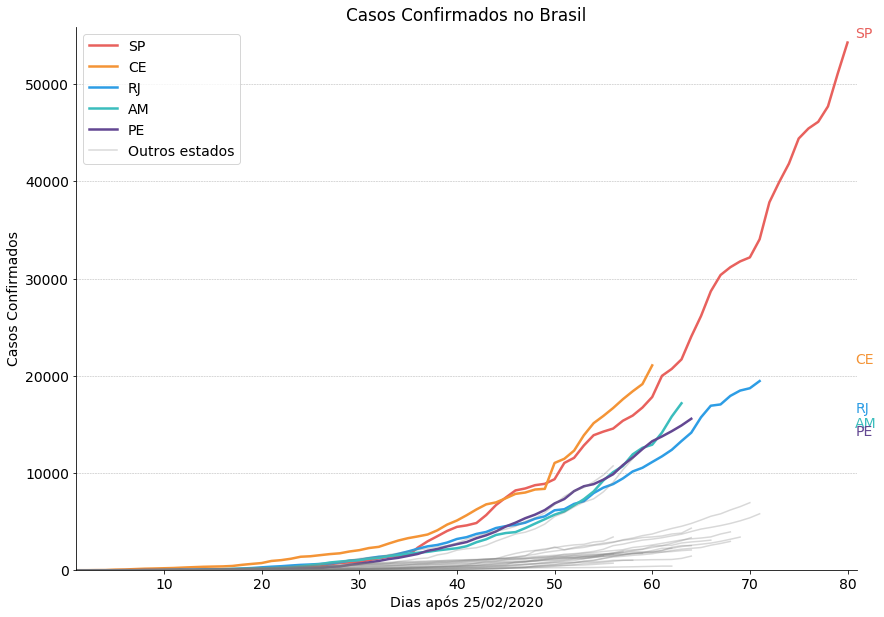

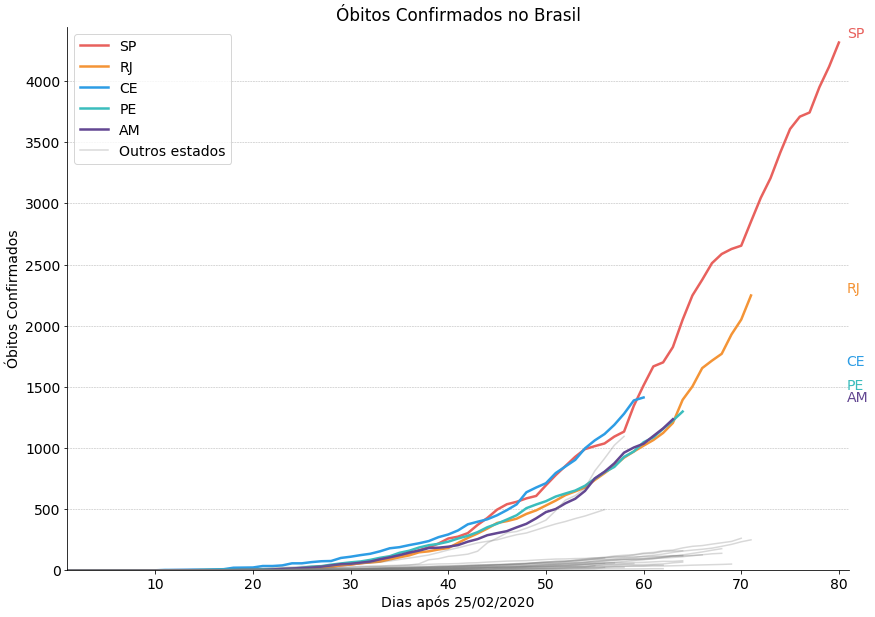

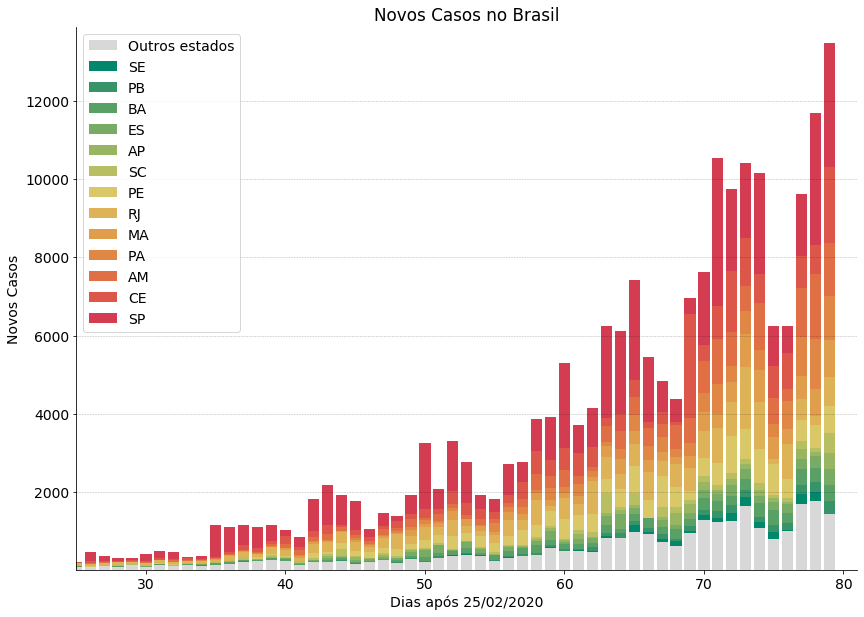

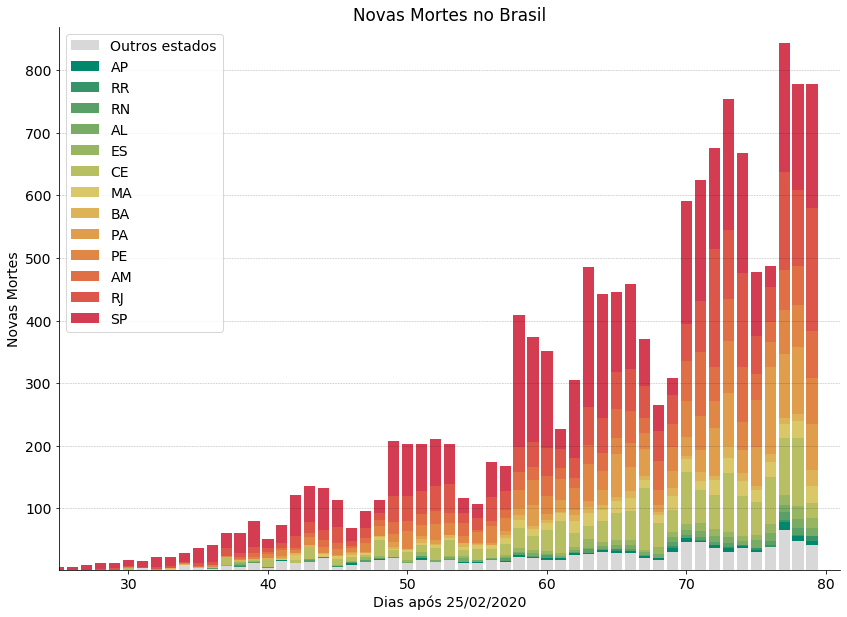

In [11]:
label = ["Estado", "Região", "População", "Último Dado", 'Data', "Dia", "Casos Confirmados", "Óbitos Confirmados",
         "Novos Casos", "Novas Mortes", "Incidência de Casos", "Mortalidade"]
reg = ['Nordeste', 'Norte', 'Sudeste', 'Sul', 'Centro Oeste']

for f in range(6, 10) :
    
    dia = max(df_estados.loc[:, 'day'])
    x_max = dia
    
    plt.rc('font', size = 14)
    plt.rcParams['figure.figsize'] = [14, 10]
    plt.tick_params(axis = "both", which = "both", bottom = "off", top = "off",    
                    labelbottom = "on", left = "off", right = "off", labelleft = "on")

    plt.grid(True, axis = 'y', linestyle = "dashed", lw = 0.5, color = "black", alpha = 0.3)
    plt.gca().spines["top"].set_visible(False)    
    plt.gca().spines["right"].set_visible(False)
    plt.gca().get_xaxis().tick_bottom()    
    plt.gca().get_yaxis().tick_left() 

    if f in [6, 7] :
        
        estados = list(df_estados.loc[df_estados['is_last'],
                                      ['state', df_estados.columns[f]]
                                     ].sort_values(df_estados.columns[f], ascending = False)['state'].unique())

        y_max = 0
        
        for e in range(27) :
            # Real data
            x = list(df_estados.loc[df_estados['state'] == estados[e], 'day'])
            y = list(df_estados.loc[df_estados['state'] == estados[e], df_estados.columns[f]])

            y_max = max(df_estados.loc[df_estados['state'] == estados[0], df_estados.columns[f]])
            y_med = max(df_estados.loc[df_estados['state'] == estados[1], df_estados.columns[f]])
            y_min = max(df_estados.loc[df_estados['state'] == estados[5], df_estados.columns[f]])

            ytab = [1.01, 1.1, 1, 1, .8]

            if (e > 5) :
                plt.plot(x, y, marker = ' ', color = (.5, .5, .5, .3), lw = 1.5)
            elif e == 5 :
                plt.plot(x, y, marker = ' ', label = 'Outros estados', color = (.5, .5, .5, .3), lw = 1.5)
            elif (e >= 2) & (e < 5) :
                plt.plot(x, y, marker = ' ', label = estados[e], color = color[e], lw = 2.5)
                ys = y_min + (y_med - y_min) / e
                plt.text(x_max * 1.01, ys, estados[e], color = color[e], fontsize = 14)
            elif (e < 2):
                plt.plot(x, y, marker = ' ', label = estados[e], color = color[e], lw = 2.5)
                plt.text(x_max * 1.01, y[-1] * 1.01, estados[e], color = color[e], fontsize = 14)

            plt.xlim(1, x_max + 1)
            plt.ylim(0, y_max * 1.03)
            
    else :
        
        estados = list(df_estados.loc[df_estados['is_last'], 
                                      ['state', df_estados.columns[f]]
                                     ].sort_values(df_estados.columns[f], ascending = True)['state'].unique())
        
        x_max = len(df_Brasil.index)
        y_max = max(df_Brasil.iloc[range(len(df_Brasil.index)), f - 6])
        
        x = list(range(25, len(df_Brasil.index)))
        y = list(df_estados.loc[df_estados['state'] == estados[0],
                                df_estados.columns[f]].tail(dia - 25).reset_index(drop = True))

        prev = y

        for e in range(1, 27) : 
            y = list(df_estados.loc[df_estados['state'] == estados[e], 
                                    df_estados.columns[f]].tail(dia - 25).reset_index(drop = True))               

            for r in range(len(Regiao)) :    
                if estados[e] in Regiao[r] :
                    if e == 14 :
                        plt.bar(x, prev, label = 'Outros estados', color = (.5, .5, .5, .3))
                    if e > 13 :  
                        plt.bar(x, y, bottom = prev, label = estados[e], color = color2[e - 14])
            prev = [sum(i) for i in zip(y, prev)]
            
#         debugging
#         x = range(len(df_Brasil.index))   
#         y = df_Brasil.iloc[:, f - 6]
#         plt.bar(x, y, label = 'Brasil', color = (0, 0, 0, .3))
        
        plt.xlim(25, x_max + 1)
        plt.ylim(1, y_max * 1.03) 
                
    plt.title(label[f] + " no Brasil")
    plt.legend(loc = 2)
    #plt.yscale('log')
    plt.xlabel("Dias após 25/02/2020")
    plt.ylabel(label[f])
    plt.savefig('Graphics/' + label[f] + " Brasil.png")
    plt.show()

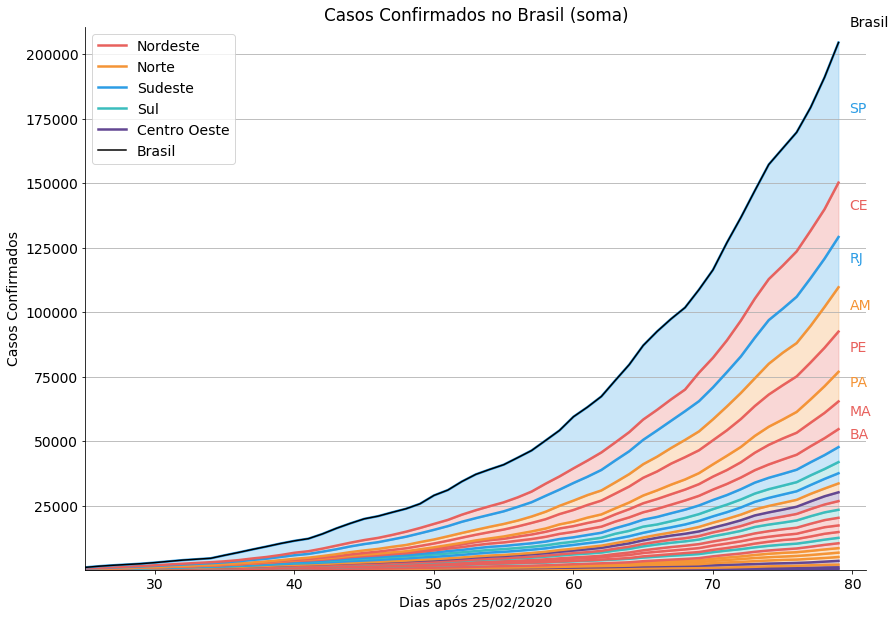

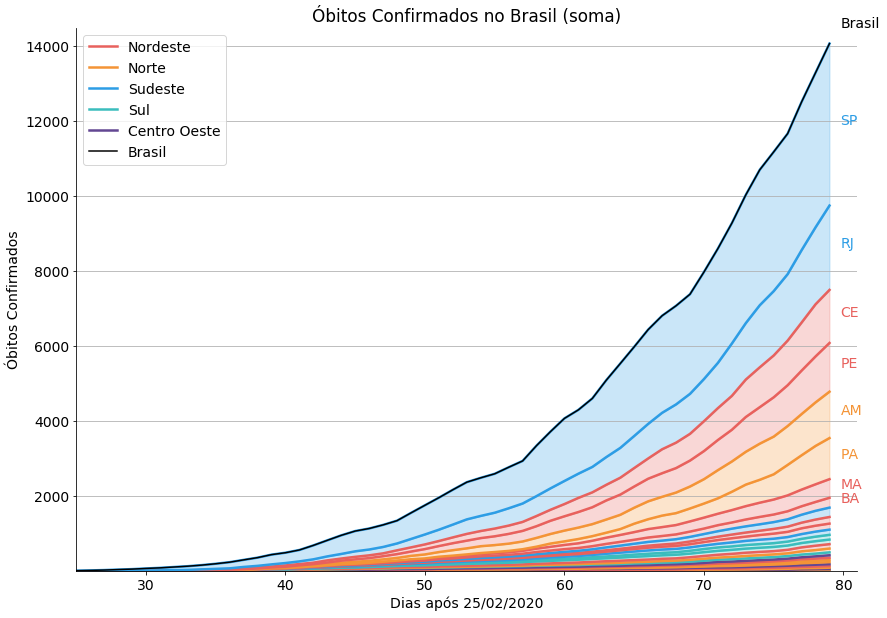

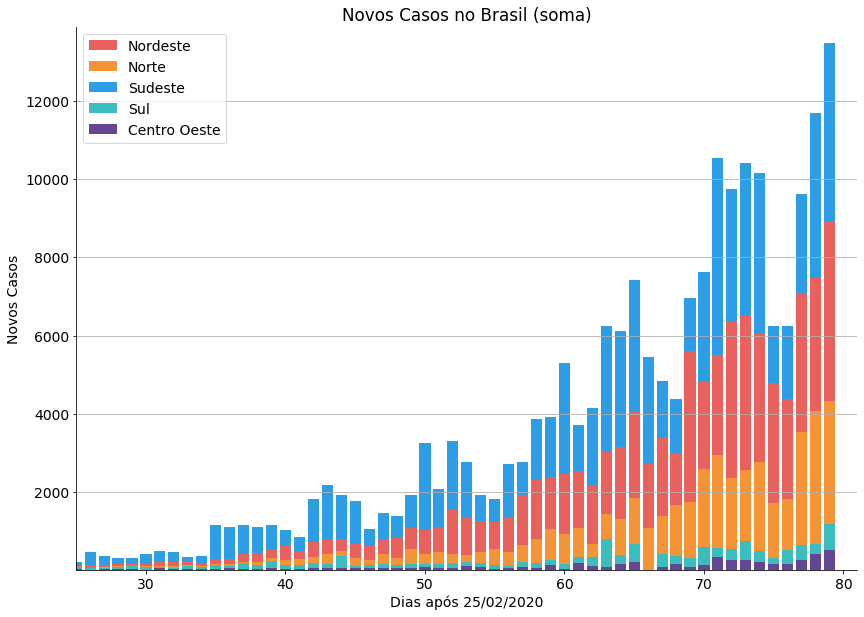

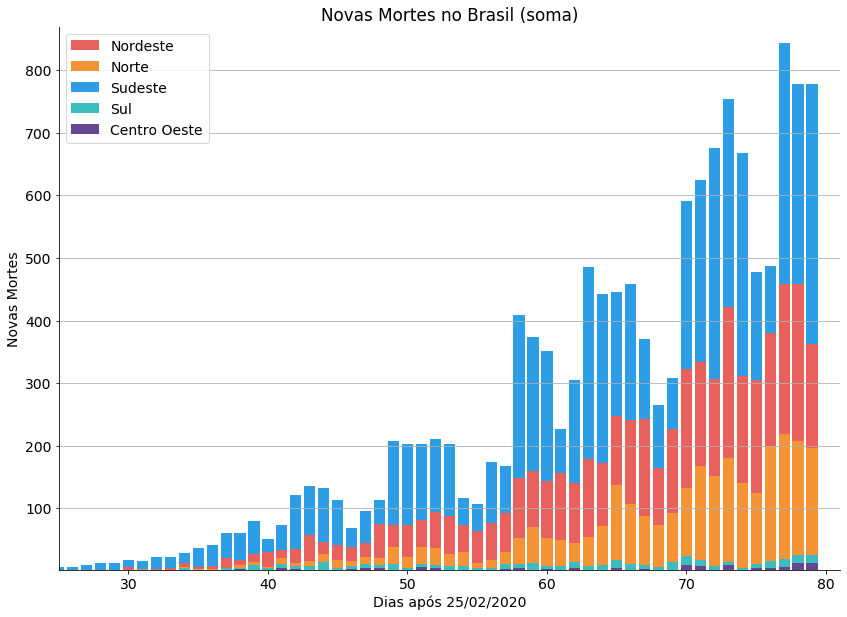

In [12]:
label = ["Estado", "Regiao", "População", "Último Dado", "Data", "Dia", "Casos Confirmados",
         "Óbitos Confirmados", "Novos Casos", "Novas Mortes", "Incidência de Casos", "Mortalidade"]

for f in range(6, 10) :
        
    plt.rc('font', size=14)
    plt.rcParams['figure.figsize'] = [14, 10]

    plt.gca().spines["top"].set_visible(False)    
    plt.gca().spines["right"].set_visible(False)
    plt.gca().get_xaxis().tick_bottom()    
    plt.gca().get_yaxis().tick_left()
    plt.grid(True, axis = 'y')
    
    if f in [6, 7] :
        dia = max(df_estados.loc[:, 'day'])
        
        reg = ['Nordeste', 'Norte', 'Sudeste', 'Sul', 'Centro Oeste']
        estados = list(df_estados.loc[df_estados['is_last'],
                                      [df_estados.columns[f], 'state']
                                     ].sort_values(df_estados.columns[f], ascending = True)['state'].unique())
        
        x_max = dia
        y_max = max(df_Brasil.iloc[range(len(df_Brasil.index)), f - 6])
        
        # Brasil data
        x = range(25, len(df_Brasil.index))
        y = list(df_estados.loc[df_estados['state'] == estados[0], 
                                df_estados.columns[f]
                               ].tail(dia - 25).reset_index(drop = True))

        for r in range(len(Regiao)) :
            plt.plot(range(5), range(5), label = reg[r], color = color[r], lw = 2.5)
            if estados[0] in Regiao[r] :
                plt.plot(x, y, marker = ' ', color = color[r], lw = 2.5)     
        temp = list(df_estados.loc[df_estados['state'] == estados[0], 
                                   df_estados.columns[f]
                                  ].tail(dia - 25).reset_index(drop = True))

        for e in range(1, 27) :                  
            tempa = temp
            tempb = list(df_estados.loc[df_estados['state'] == estados[e], 
                                        df_estados.columns[f]
                                       ].tail(dia - 25).reset_index(drop = True))               
            y = [sum(i) for i in zip(temp, tempb)]
            temp = y

            for r in range(len(Regiao)) :    
                if estados[e] in Regiao[r] :
                    plt.plot(x, y, marker = ' ', color = color[r], lw = 2.5)
                    if e > 18 :
                        plt.text(max(x) * 1.01, (max(temp) + max(tempa)) * 0.5, estados[e], color = color[r], fontsize = 14)
                    plt.fill_between(x, temp, tempa, color = (color[r] + '40'))

        # Brasil data
        x = range(len(df_Brasil.index))
        y = list(df_Brasil.iloc[x, f - 6])
        plt.plot(x, y, color = 'black', label = "Brasil", lw = 1.5) 
        plt.text(max(x) * 1.01, y[-1] * 1.03, "Brasil", color = "black", fontsize = 14)               

        plt.xlim(25, x_max + 1)
        plt.ylim(1, y_max * 1.03)
    
    else :
        dia = len(df_Brasil.index)
        
        df_estados['region'] = 'null'
        reg = ['B Nordeste', 'C Norte', 'A Sudeste', 'D Sul', 'E Centro Oeste']
        for r in range(len(Regiao)) :
            for a in range(len(Regiao[r])) :
                df_estados.loc[df_estados['state'].eq(Regiao[r][a]), 'region'] = reg[r]
        
        estados = list(df_estados.loc[df_estados['is_last'],
                                      ['state', 'region']
                                     ].sort_values('region', ascending = False)['state'].unique())
        
        x_max = len(df_Brasil.index)
        y_max = max(df_Brasil.iloc[range(len(df_Brasil.index)), f - 6])
        
        x = list(range(25, len(df_Brasil.index)))
        y = list(df_estados.loc[df_estados['state'] == estados[0], 
                                df_estados.columns[f]
                               ].tail(dia - 25).reset_index(drop = True))

        for r in range(len(Regiao)) :
            plt.bar(range(1), range(1), label = str(reg[r])[2:], color = color[r])
            if estados[0] in Regiao[r] :
                plt.bar(x, y, color = color[r])    

        prev = y

        for e in range(1, 27) :                
            y = list(df_estados.loc[df_estados['state'] == estados[e], 
                                    df_estados.columns[f]
                                   ].tail(dia - 25).reset_index(drop = True))               

            for r in range(len(Regiao)) :    
                if estados[e] in Regiao[r] :
                    plt.bar(x, y, bottom = prev, color = color[r])
            prev = [sum(i) for i in zip(y, prev)]
     
        plt.xlim(25, x_max + 1)
        plt.ylim(1, y_max * 1.03)    
        
    plt.title(label[f] + " no Brasil (soma)")
    plt.legend(loc = 2, ncol = 1)
    plt.xlabel("Dias após 25/02/2020")
    plt.ylabel(label[f])
    plt.savefig('Graphics/' + label[f] + " Brasil soma.png")
    plt.show()


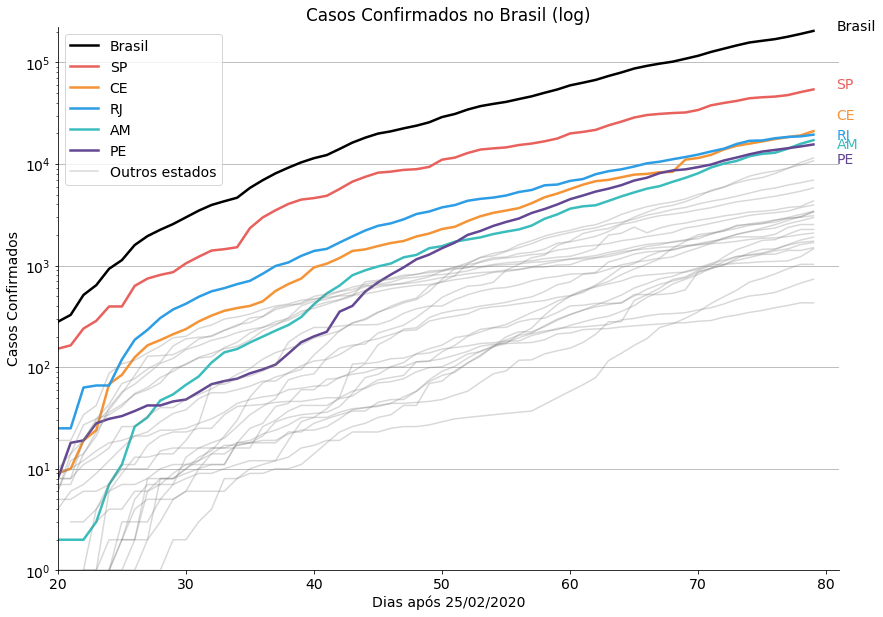

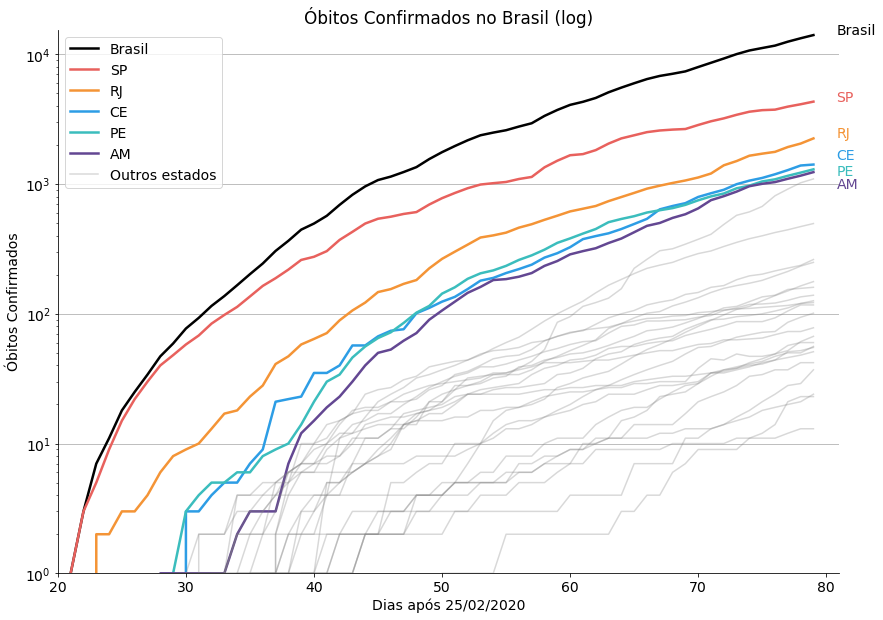

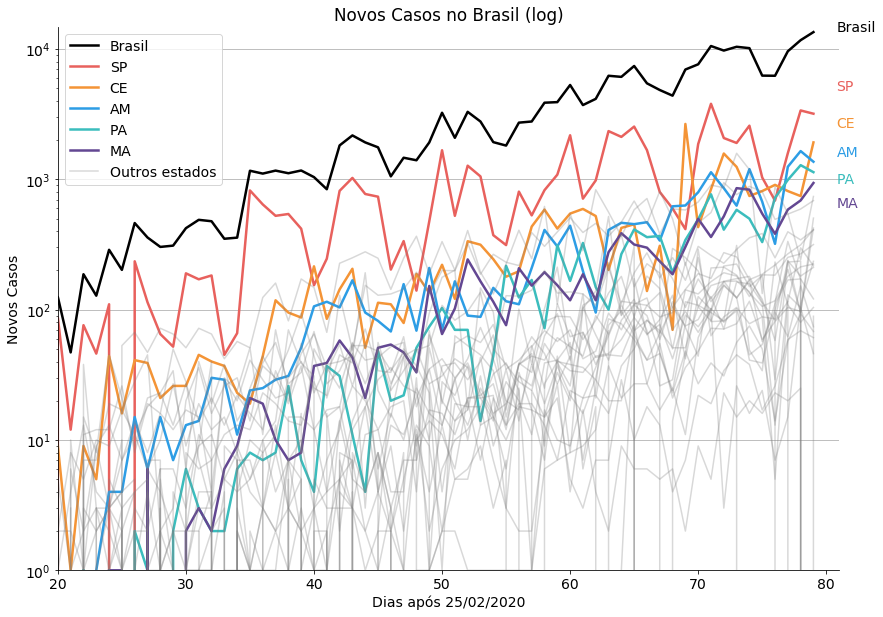

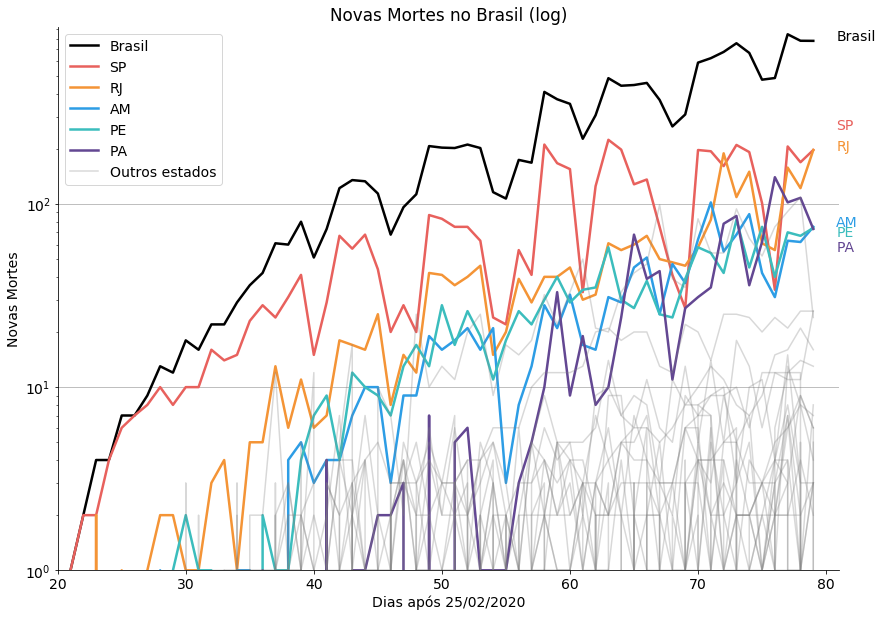

In [13]:
label = ["Estado", "Regiao", "População", "Último Dado", "Data", "Dia", "Casos Confirmados",
         "Óbitos Confirmados", "Novos Casos", "Novas Mortes", "Incidência de Casos", "Mortalidade"]

dia = len(df_Brasil.index)

for f in range(6, 10) :

    plt.rc('font', size = 14)
    plt.rcParams['figure.figsize'] = [14, 10]

    plt.gca().spines["top"].set_visible(False)    
    plt.gca().spines["right"].set_visible(False)
    plt.gca().get_xaxis().tick_bottom()    
    plt.gca().get_yaxis().tick_left()
    plt.grid(True, axis = 'y')

    estados = list(df_estados.loc[df_estados['is_last'], 
                                  [df_estados.columns[f], 'state']                              
                                 ].sort_values(df_estados.columns[f], ascending = False)['state'].unique())
    
    # Brasil data
    x = list(df_Brasil.index.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-02-25", FMT)).days))
    x_max = dia

    y = list(df_Brasil.iloc[:, f - 6])
    y_max = max(df_Brasil.iloc[:, f - 6])
    
    plt.plot(x, y, marker = ' ', color = 'black', label = "Brasil", lw = 2.5) 
    plt.text(x_max * 1.01, 1.01 * y[-1], "Brasil", color = "black", fontsize = 14)   

    for e in range(27) :  

        x = list(df_estados.loc[df_estados['state'] == estados[e], 'date'].map(lambda x : (datetime.strptime(x, FMT) - 
                                                                                                     datetime.strptime("2020-02-25", FMT)).days))
        y = list(df_estados.loc[df_estados['state'] == estados[e], df_estados.columns[f]])
        ytab = [[0], [0], [0], [0], [0], [0],
                [1.01, 1.3, .9, .82, .65], [1.01, 1.01, 1.1, .9, .75],
                [1.5, 1.3, 1.1, .82, .65], [1.3, 1, 1, .9, .75]]

        if e < 5 :
            plt.plot(x, y, marker = ' ', label = estados[e], color = color[e], lw = 2.5)
            
            if y[-1] > 0 :
                plt.text(x_max * 1.01, y[-1] * ytab[f][e], estados[e], color = color[e], fontsize = 14)
            elif y[-2] > 0 :
                plt.text(x_max * 1.01, y[-2] * ytab[f][e] * .1, estados[e], color = color[e], fontsize = 14)
            elif y[-3] > 0 :
                plt.text(x_max * 1.01, y[-3] * ytab[f][e] * .1, estados[e], color = color[e], fontsize = 14)
        
        elif e == 5 :
            plt.plot(x, y, marker = ' ', label = 'Outros estados', color = (.5, .5, .5, .3), lw = 1.5)
        else :
            plt.plot(x, y, marker = ' ', color = (.5, .5, .5, .3), lw = 1.5)

    plt.xlim(20, x_max + 1)
    plt.ylim(1, y_max * 1.1)       
        
    plt.title(label[f] + " no Brasil (log)")
    plt.legend(loc = 2)
    plt.yscale('log')
    plt.xlabel("Dias após 25/02/2020")
    plt.ylabel(label[f])
    plt.savefig('Graphics/' + label[f] + " Brasil log.png")
    plt.show()
